In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

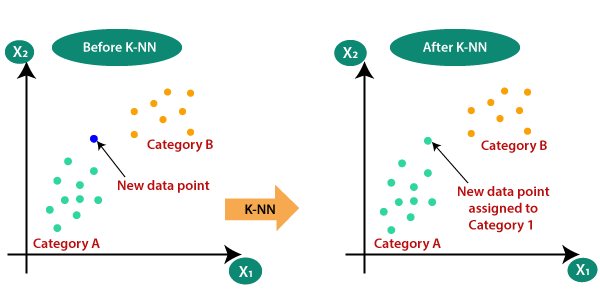

#KNN CLASSIFIERS
* Non-parametric
* Commonly used distance metric is the Euclidean distance

$d(x,y) = \sqrt(\sum(x_i - y_i)^2)$

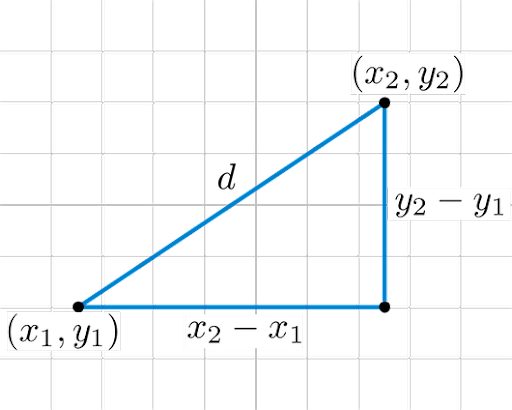

# Data Loading and General Overview

In [30]:
df = pd.read_csv("../input/kopacsv/KOPA.csv")
df.head(2)

Product CustomerGender    Location    Region  TotalPrice StartDate  \
0  Product B           Male  Location 2  Region 2       16600  7/4/2014   
1  Product B           Male  Location 3  Region 3       16600  1/2/2015   

   Deposit  DailyRate  TotalDays  AmountPaid30  AmountPaid60  AmountPaid360  \
0     2000         40        365          3121          4241          13621   
1     2000         40        365          3061          4171          15041   

  LoanStatus360  
0        Active  
1        Active

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9195 entries, 0 to 9194
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product         9195 non-null   object
 1   CustomerGender  9195 non-null   object
 2   Location        9195 non-null   object
 3   Region          9195 non-null   object
 4   TotalPrice      9195 non-null   int64 
 5   StartDate       9195 non-null   object
 6   Deposit         9195 non-null   int64 
 7   DailyRate       9195 non-null   int64 
 8   TotalDays       9195 non-null   int64 
 9   AmountPaid30    9195 non-null   int64 
 10  AmountPaid60    9195 non-null   int64 
 11  AmountPaid360   9195 non-null   int64 
 12  LoanStatus360   9195 non-null   object
dtypes: int64(7), object(6)
memory usage: 934.0+ KB


Text(0.5, 1.0, 'Distribution of Target Variable')

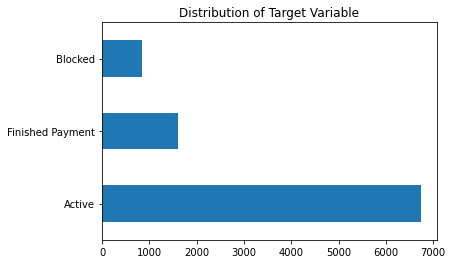

In [32]:
df['LoanStatus360'].value_counts().plot(kind='barh')
plt.title("Distribution of Target Variable")

# Data Preprocessing/Cleaning. 
1. Label encoding of Categorical features
2. Handling date-time columns
3. Feature interaction(subjective)
4. Scaling(subjective)

In [33]:
df.head(2)

Product CustomerGender    Location    Region  TotalPrice StartDate  \
0  Product B           Male  Location 2  Region 2       16600  7/4/2014   
1  Product B           Male  Location 3  Region 3       16600  1/2/2015   

   Deposit  DailyRate  TotalDays  AmountPaid30  AmountPaid60  AmountPaid360  \
0     2000         40        365          3121          4241          13621   
1     2000         40        365          3061          4171          15041   

  LoanStatus360  
0        Active  
1        Active

# Handling categorical data

In [37]:
cat_cols = ['Product', 'CustomerGender', 'Location', 'Region']
def frequency_encoding(df, col):
    fe = df.groupby(col).size()/len(df)
    df[col+"_encoded"] = df[col].map(fe)
    return df
new_df = frequency_encoding(df, 'Product')
new_df = frequency_encoding(new_df, 'CustomerGender')
new_df = frequency_encoding(new_df, 'Location')
new_df = frequency_encoding(new_df, 'Region')
new_df = new_df.drop(columns=cat_cols, axis=1)
new_df.head(2)

TotalPrice StartDate  Deposit  DailyRate  TotalDays  AmountPaid30  \
0       16600  7/4/2014     2000         40        365          3121   
1       16600  1/2/2015     2000         40        365          3061   

   AmountPaid60  AmountPaid360 LoanStatus360  Product_encoded  \
0          4241          13621        Active         0.420011   
1          4171          15041        Active         0.420011   

   CustomerGender_encoded  Location_encoded  Region_encoded  
0                0.582708          0.009027        0.148341  
1                0.582708          0.026536        0.211093

# Handling datetime

In [39]:
new_df['StartDate'] = pd.to_datetime(new_df['StartDate'])
new_df.head(2)

TotalPrice  StartDate  Deposit  DailyRate  TotalDays  AmountPaid30  \
0       16600 2014-07-04     2000         40        365          3121   
1       16600 2015-01-02     2000         40        365          3061   

   AmountPaid60  AmountPaid360 LoanStatus360  Product_encoded  \
0          4241          13621        Active         0.420011   
1          4171          15041        Active         0.420011   

   CustomerGender_encoded  Location_encoded  Region_encoded  
0                0.582708          0.009027        0.148341  
1                0.582708          0.026536        0.211093

In [40]:
new_df['Year'] = new_df['StartDate'].dt.year
new_df['month'] = new_df['StartDate'].dt.month
new_df['date'] = new_df['StartDate'].dt.day
new_df.columns

Index(['TotalPrice', 'StartDate', 'Deposit', 'DailyRate', 'TotalDays',
       'AmountPaid30', 'AmountPaid60', 'AmountPaid360', 'LoanStatus360',
       'Product_encoded', 'CustomerGender_encoded', 'Location_encoded',
       'Region_encoded', 'Year', 'month', 'date'],
      dtype='object')

In [41]:
new_df = new_df.drop(columns=['StartDate'], axis=1)

# Feature interaction

In [42]:
#feature interaction
new_df['loan_amount_paid'] = new_df['TotalDays'] * new_df['DailyRate']
new_df['AmountPaidSum'] = new_df['AmountPaid30']+new_df['AmountPaid60'] + new_df['AmountPaid360']


# Modelling

In [44]:
X = new_df.drop(columns=['LoanStatus360'], axis=1)
y = new_df['LoanStatus360']

In [45]:
le = LabelEncoder()
y = le.fit_transform(y)

In [49]:
#using default hyperparameters
model1 = KNeighborsClassifier()
result = cross_val_score(model1, X, y, n_jobs=-1, scoring='accuracy')
final_result = np.mean(result)
final_result

0.9303969548667755

# Hyper-parameter tuning: Bayesian Optimization
* Bayesian  optimization is ideal in instances where we have a large number of hyperparameters
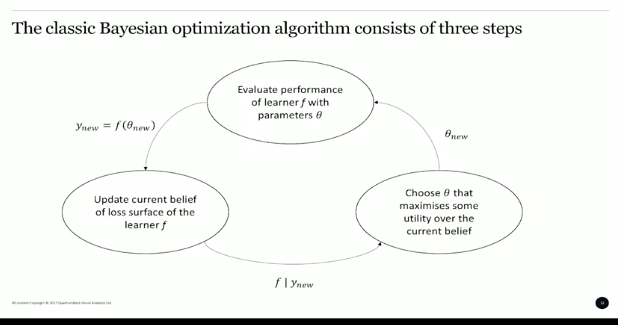

* Here, $\theta$ are our parameters
* For a classification problem, the performance metric may be the accuracy or auc score, for regression it may be the rmse, mse, mae etc
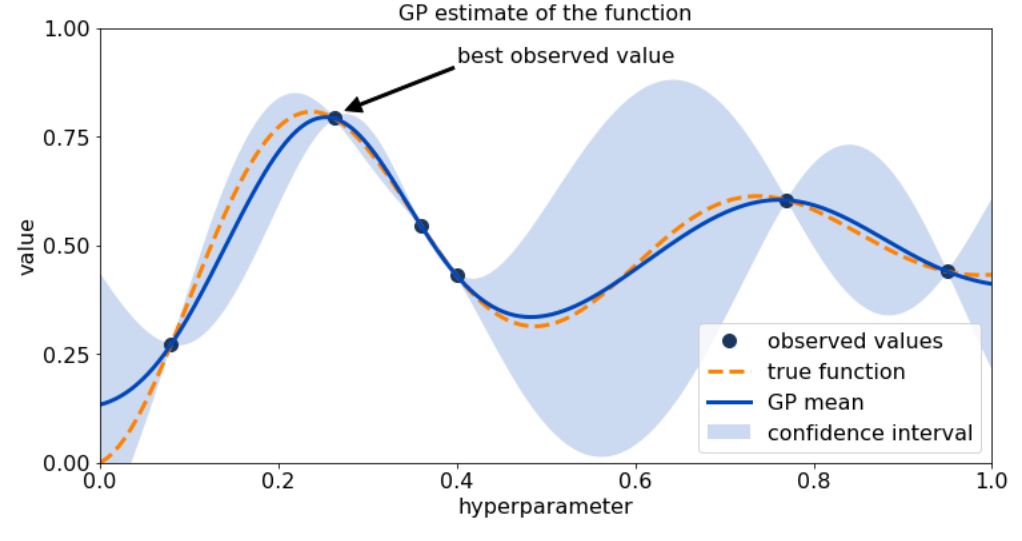
* GP is a gaussian distribution applied over a distribution of functions rather than a distribution of random variables. (in this case function is the model developed). 
* GP is defined by its mean function and covariance function(analoguous to mean and variance in random variables). 
* Blue dots ==> where the function has been evaluated and we are certain of the results. 
* We can see that the variance is low and we have low uncertainity. 
* Places with high uncertainties are places where we haven't evaluated the function
* How do we know which regions to explore next to minimize our variance, i.e improve our performance? Using acquisition functions. 
* Commonly used acquisition functions include:
    1. Expected improvement functions
    2. Probability of improvement. 
    3. Lower confidence bound function
* Focusing on expected improvement:
    $EI(\theta) = E[max_\theta [ 0, (yi(\theta)-y_{i-1}(\theta))]]$ 
* Exploration vs Exploitation: strategies used in improving the performance of the model. Need to know which one to work with. 

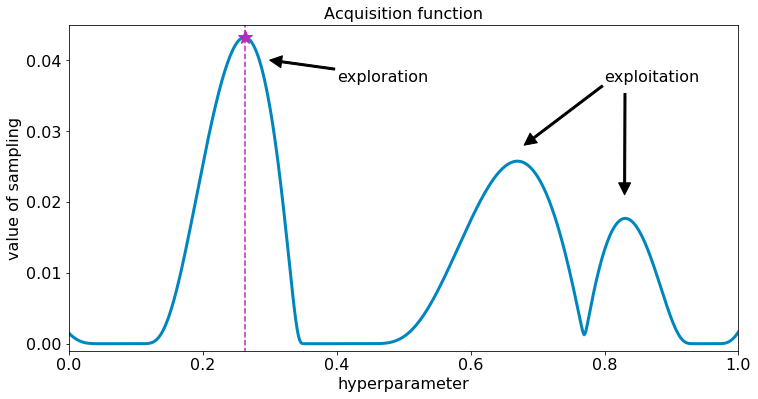

* Result of Bayesian Optimization in SVC
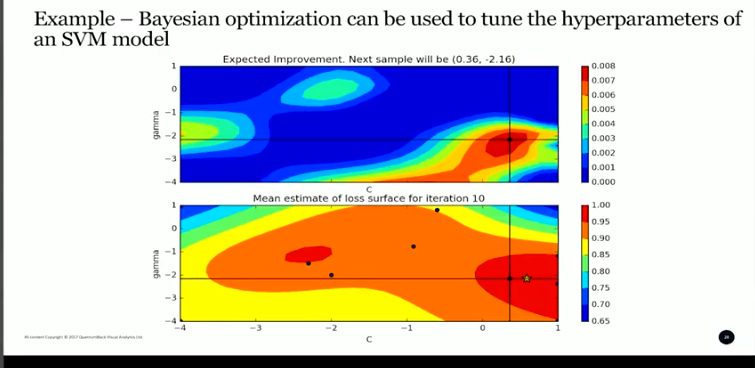

In [46]:
%%time
##Objective of this step is to obtain optimum parameters that will yield the best result.
## It is not guaranteed that the performance will change drastically
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]
 
# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = np.mean(result)
	return 1.0 - estimate
 
# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/opt/conda/lib/python3.7/site-packa

Best Accuracy: 0.931
Best Parameters: n_neighbors=4, p=1
CPU times: user 1min 45s, sys: 1min 14s, total: 2min 59s
Wall time: 1min 36s
